# Анализ результатов АБ-теста

В данном задании вам нужно будет

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
%matplotlib inline
from matplotlib import pyplot as plt
from statsmodels.sandbox.stats.multicomp import multipletests 

In [18]:
import scipy
from scipy.stats import probplot

## Описание данных:

userID: уникальный идентификатор пользователя
browser: браузер, который использовал userID
slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
n_clicks: количество кликов, которые пользоваль совершил за n_queries
n_queries: количество запросов, который совершил userID, пользуясь браузером browser
n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика
Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.


In [2]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


### Задание 1.
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [3]:
data.browser.value_counts()

Browser #4     156833
Browser #22    142905
Browser #2     110737
Browser #14     89123
Browser #20     33929
Browser #17     32607
Name: browser, dtype: int64

In [4]:
data[data.slot=='exp'].median()

userID              299057.0
n_clicks                 5.0
n_queries                5.0
n_nonclk_queries         2.0
dtype: float64

In [5]:
data.slot.value_counts()

control    284554
exp        281580
Name: slot, dtype: int64

In [6]:
data[data.slot=='control'].median()

userID              299620.5
n_clicks                 4.0
n_queries                5.0
n_nonclk_queries         2.0
dtype: float64

In [7]:
n_control, n_exp = data.groupby(['slot']).n_clicks.sum()

In [8]:
(n_exp/n_control-1)*100

1.6135689824415822

### Задание 2.
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [9]:
def iter_bootstrap_samples(data, n_samples):
    i = 0
    while i < n_samples:
        indices = np.random.randint(0, len(data), len(data))
        sample = data[indices]
        yield sample
        i += 1

In [14]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
limean, limedian=[], []
for i,j in zip(iter_bootstrap_samples(data[data.slot == 'exp'].n_clicks.values, 10000), iter_bootstrap_samples(data[data.slot == 'control'].n_clicks.values, 10000)):
    limean.append(np.mean(i) - np.mean(j))
    limedian.append(np.median(i) - np.median(j))

In [15]:
print('mean ', stat_intervals(limean, 0.05))
print('median ', stat_intervals(limedian, 0.05))

mean  [0.19601687 0.4086502 ]
median  [1. 1.]


Ответ:
 - 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо

 - 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо


In [16]:
exp_clicks_mean = list(map(np.mean, data[data.slot=='exp'].n_clicks.values))
control_clicks_mean = list(map(np.mean, data[data.slot=='control'].n_clicks.values))

### Задание 3-4. 
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.
Чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:
 - среднее значение в выборке было распределено нормально
 - несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы.
 
Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

1. Получите из данных n_boot_samples псевдовыборок.
2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды scipy.stats.probplot

Чтобы получить такой же ответ, как у нас, зафиксируйте seed = 0 и количество псевдовыборок = 500:

В качестве ответа отметьте сделайте заключение на основании значений R2, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.


In [19]:
np.random.seed(0)
n_boot_samples = 500
limean2, listd = [], []
for i in iter_bootstrap_samples(data[data.slot == 'control'].n_clicks.values, n_boot_samples):
    limean2.append(np.mean(i))
    listd.append(scipy.std(i))

0.9979748364604202


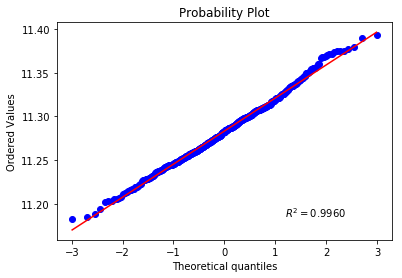

In [45]:
_, r_mean = probplot(limean2, plot=plt, rvalue=True);
print(r_mean[2])

0.9986400904214093


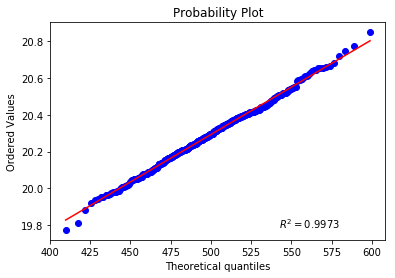

In [46]:
_, r_std=probplot(listd, sparams=(len(listd)-1), dist="chi2", plot=plt, rvalue=True)
print(r_std[2])

Ответ:
 - $$R^2$$ для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99

 - $$R^2$$ для выборочного среднего получился больше, чем 0.99

### 5. Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [24]:
control_s = data[data.slot == 'control'].groupby(by=['userID']).n_clicks.sum()
exp_s = data[data.slot == 'exp'].groupby(by=['userID']).n_clicks.sum()

In [26]:
sts.mannwhitneyu(control_s, exp_s)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Ответ:
Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками

### 6. Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.


In [22]:
gr = data.groupby(by=['browser'])

In [32]:
dick = {}
for name, group in gr:
    grr = group.groupby(by=['slot'])
    dick[name] = mannwhitneyu(grr.get_group('control').n_clicks, grr.get_group('exp').n_clicks, alternative='two-sided')

In [33]:
dick

{'Browser #14': MannwhitneyuResult(statistic=806984730.5, pvalue=0.0),
 'Browser #17': MannwhitneyuResult(statistic=131389681.0, pvalue=0.07480120286021603),
 'Browser #2': MannwhitneyuResult(statistic=1522572720.0, pvalue=0.0544877208394482),
 'Browser #20': MannwhitneyuResult(statistic=143791805.0, pvalue=0.9073331277747075),
 'Browser #22': MannwhitneyuResult(statistic=2557723040.5, pvalue=0.5148110304420064),
 'Browser #4': MannwhitneyuResult(statistic=3072447765.0, pvalue=0.8152123531690997)}

In [34]:
df = pd.DataFrame.from_dict(dick).T
df.columns = ['statistic', 'pval']

In [35]:
reject, pval, a1, a2 = multipletests(df.statistic, alpha=0.05, method='holm')
df['corrected'] = pval
df['reject'] = reject

In [36]:
df

,statistic,pval,corrected,reject
Browser #14,8.069847e+08,0.000000,1.0,False
Browser #17,1.313897e+08,0.074801,1.0,False
Browser #2,1.522573e+09,0.054488,1.0,False
Browser #20,1.437918e+08,0.907333,1.0,False
Browser #22,2.557723e+09,0.514811,1.0,False
Browser #4,3.072448e+09,0.815212,1.0,False


### 7. Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ?

In [56]:
dicck = {}
ggrm = data.groupby(by=['browser', 'slot'])
for name, group in ggrm:
    dicck[name] = group['n_nonclk_queries'].sum()/group['n_queries'].sum()

In [57]:
dicck

{('Browser #14', 'control'): 0.5759041136008114,
 ('Browser #14', 'exp'): 0.43755617361273291,
 ('Browser #17', 'control'): 0.36299366746282086,
 ('Browser #17', 'exp'): 0.3693741284866483,
 ('Browser #2', 'control'): 0.45962747179194652,
 ('Browser #2', 'exp'): 0.44982746948554703,
 ('Browser #20', 'control'): 0.40540484743383293,
 ('Browser #20', 'exp'): 0.38977376483717158,
 ('Browser #22', 'control'): 0.40593976593513353,
 ('Browser #22', 'exp'): 0.39853947219695463,
 ('Browser #4', 'control'): 0.46970929635142739,
 ('Browser #4', 'exp'): 0.45142941903584671}

In [28]:
dh = data

In [29]:
x = dh[(dh.browser=='Browser #4') & (dh.slot=='exp')].n_clicks.values
y = dh[(dh.browser=='Browser #4') & (dh.slot=='control')].n_clicks.values
n1 = len(x)
n2 = len(y)
ranked = sts.rankdata(np.concatenate((x, y)))
rankx = ranked[0:n1]  # get the x-ranks
u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
u2 = n1*n2 - u1  # remainder is U for y
T = sts.tiecorrect(ranked)
if T == 0:    
    raise ValueError('All numbers are identical in amannwhitneyu')
sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)
meanrank = n1*n2/2.0 + 0.5 
bigu = max(u1, u2)
z = np.abs(bigu - meanrank)
fact2 = 2.
z = z / sd
p_value = sts.norm.sf(z) * fact2

In [30]:
p_value

0.8152123531690997

In [89]:
import warnings

In [31]:
from collections import namedtuple
MannwhitneyuResult = namedtuple('MannwhitneyuResult', ('statistic', 'pvalue'))
def tiecorrect(rankvals):
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)
    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)

def mannwhitneyu(x, y, use_continuity=True, alternative=None):
    if alternative is None:
        warnings.warn("Calling `mannwhitneyu` without specifying "
                      "`alternative` is deprecated.", DeprecationWarning)

    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)
    ranked = sts.rankdata(np.concatenate((x, y)))
    rankx = ranked[0:n1]  # get the x-ranks
    u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
    u2 = n1*n2 - u1  # remainder is U for y
    T = tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in mannwhitneyu')
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)

    meanrank = n1*n2/2.0 + 0.5 * use_continuity
    if alternative is None or alternative == 'two-sided':
        bigu = max(u1, u2)
    elif alternative == 'less':
        bigu = u1
    elif alternative == 'greater':
        bigu = u2
    else:
        raise ValueError("alternative should be None, 'less', 'greater' "
                         "or 'two-sided'")
    z = (bigu - meanrank) / sd
    if alternative is None:
        # This behavior, equal to half the size of the two-sided
        # p-value, is deprecated.
        p = sts.distributions.norm.sf(abs(z))
    elif alternative == 'two-sided':
        p = 2 * sts.distributions.norm.sf(abs(z))
    else:
        p = sts.distributions.norm.sf(z)
    u = u2
    # This behavior is deprecated.
    if alternative is None:
        u = min(u1, u2)
    return MannwhitneyuResult(u, p)